In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 1. 데이터 전처리

## 1-1. 메타버스 부동산 가격 데이터

In [2]:
# 메타버스 최초 크롤링데이터
df = pd.read_csv("meta_data_all_min.csv") 

In [3]:
# 특정 컬럼 유니크 값 개수 확인 >> 불필요한 컬럼 제거 목적
df["createdAt"].value_counts()

2021-09-16T08:44:50.296Z    7
2021-10-08T09:09:01.262Z    6
2021-12-03T14:25:02.644Z    6
2021-11-08T09:28:56.826Z    6
2021-11-04T11:59:37.047Z    6
                           ..
2021-09-18T05:10:53.096Z    1
2021-09-23T10:33:54.111Z    1
2021-10-25T10:51:11.583Z    1
2021-09-24T08:47:02.157Z    1
2021-10-15T00:34:12.512Z    1
Name: createdAt, Length: 41758, dtype: int64

In [4]:
# df[["createdAt","totalPrice"]].sort_values("createdAt")

In [5]:
# 한국 서울 주소지 값만 추출
df_korea = df[df["address"].str.contains("Seoul")==True]
df_korea.head(1)

,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]"


In [6]:
# 구별로 나타내기
df_gu_list = df_korea["address"].to_list()

a = []
for i in range(len(df_gu_list)):
    gu_list = df_gu_list[i].split()[3]
    a.append(gu_list)

df_korea["gu_address"] = a
df_korea.head(1)

<ipython-input-6-1b0c9955818a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_korea["gu_address"] = a


,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates,gu_address
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu


In [7]:
# 센트 > 달러 > 원 단위 환산
df_korea["totalPrice/100*1200"] = df_korea["totalPrice"]/100*1200
df_korea["boughtPrice/100*1200"] = df_korea["boughtPrice"]/100*1200
df_korea.head(1)

<ipython-input-7-ff60db35ecfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_korea["totalPrice/100*1200"] = df_korea["totalPrice"]/100*1200
<ipython-input-7-ff60db35ecfc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_korea["boughtPrice/100*1200"] = df_korea["boughtPrice"]/100*1200


,Unnamed: 0,isMyTile,lastPage,currentPage,allSellOrdersCount,currentSellOrderCount,sellOrderId,uuid,boughtPrice,totalPrice,createdAt,sellerId,sellerReferralCode,memo,address,coordinates,gu_address,totalPrice/100*1200,boughtPrice/100*1200
1,1,False,5297,1,52968,2,377297,056274a0-4a2d-45e0-bc93-43062e74ac60,16348160,32696320,2021-12-13T14:31:35.935Z,17253,ohKCKOZT50RU,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu,392355840.0,196177920.0


In [8]:
# 불필요한 컬럼 제거
df_1 = df_korea.drop(["uuid","Unnamed: 0","sellOrderId","allSellOrdersCount","lastPage","currentPage","currentSellOrderCount","isMyTile","sellerReferralCode"], axis = 1)
df_1.head(1)


,boughtPrice,totalPrice,createdAt,sellerId,memo,address,coordinates,gu_address,totalPrice/100*1200,boughtPrice/100*1200
1,16348160,32696320,2021-12-13T14:31:35.935Z,17253,Jamsil-dong,South Korea Seoul Songpa-gu 05608 Jamsil-dong ...,"[127.09868431091309, 37.51047477627239]",Songpa-gu,392355840.0,196177920.0


In [9]:
# 필요한 컬럼 추출 : 메타버스 시장가격 (단위 : 센트>달러>원 , 고정환율 : 1,200원)
df_meta = pd.DataFrame()
df_meta["boughtPrice"] = df_1["boughtPrice/100*1200"]
df_meta["totalPrice"] = df_1["totalPrice/100*1200"]
df_meta["gu_address"] = df_1["gu_address"]
df_meta["dong_address"] = df_1["memo"]

# df_meta_index = df_meta.set_index(['gu_address','dong_address'])
df_meta

,boughtPrice,totalPrice,gu_address,dong_address
1,196177920.0,392355840.0,Songpa-gu,Jamsil-dong
2,176821632.0,353643552.0,Songpa-gu,Sincheon-dong
4,133792656.0,267585312.0,Songpa-gu,Sincheon-dong
5,122780448.0,245560896.0,Yeongdeungpo-gu,Yeouido-dong
7,103072632.0,206145264.0,Songpa-gu,Sincheon-dong
...,...,...,...,...
49408,240.0,480.0,Gangseo-gu,Magok-dong
49821,240.0,480.0,Gangnam-gu,Dogok-dong
49962,240.0,480.0,Yongsan-gu,Ichon-dong
50178,240.0,480.0,Gangseo-gu,Magok-dong


## 1-2. 현실 부동산 가격 데이터

In [10]:
# 현실 공시지가 데이터  (출처 : http://stat.molit.go.kr/portal/cate/statView.do?hRsId=25&hFormId=6214&hSelectId=6214&sStyleNum=1&sStart=2020&sEnd=2020&hPoint=0&hAppr=1&oFileName=&rFileName=&midpath=)
df_real = pd.read_excel("01.토지_소유구분별_기본_현황_시군구.xlsx")

df_real = df_real[["시도", "시군구","합 계", "Unnamed: 3","Unnamed: 4"]]
df_real.columns = ["시도","시군구","면적", "지번수","가액"]
df_real = df_real.iloc[3:28, 0:6].fillna("서울특별시")



공식 : 가액 = 면적 * (지분) * 개별공시지가 * 50/100   (국유지랑 사유지가 모두 포함되어 있기 때문에, 지분은 1로 계산함)

따라서, 가액 * 2 / 면적 = 개별공시지가

In [11]:
# df_real 데이터 프레임의 단위 > 면적 : km^2 , 가액 : 10억원
# 면적 단위 km^2 > m^2 로 맞추기
df_real["면적"] = df_real["면적"] * 1000000


# 개별공시지가 (단위 : 10억원)
df_real["개별공시지가"] = df_real["가액"] * 2 / df_real["면적"]
df_real.head(5)

,시도,시군구,면적,지번수,가액,개별공시지가
3,서울특별시,종로구,23913168.3,49.277,73699.545799,0.006164
4,서울특별시,중구,9960304.5,35.692,91727.388150,0.018419
5,서울특별시,용산구,21866144.1,45.009,86386.603768,0.007901
6,서울특별시,성동구,16861003.9,26.882,51293.696805,0.006084
7,서울특별시,광진구,17062938.6,32.794,46846.790664,0.005491


# 2. 데이터 분석

## 2-1. 가설1 : 현재 부동산(토지)가격이 메타버스2 가상부동산 가격형성과 관계가 있다.

<AxesSubplot:>

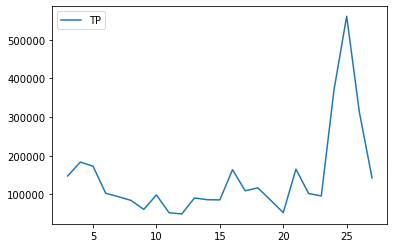

In [12]:
df_real["TP"] = df_real["면적"] * df_real["개별공시지가"]
df_real_clu = df_real[["시군구", "TP"]]
df_real_clu.plot()

<AxesSubplot:xlabel='시군구', ylabel='TP'>

/Users/parksungwon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksungwon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksungwon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksungwon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksungwon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksungwon/opt/anaconda3/li

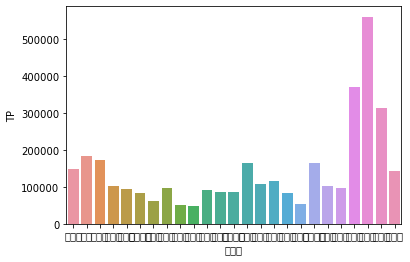

In [13]:
sns.barplot(data= df_real_clu, x = "시군구", y = "TP")

In [14]:
df_meta["gu_address"].value_counts()

Gangnam-gu         2690
Songpa-gu          2480
Jongno-gu          2135
Seocho-gu          2102
Yongsan-gu         1976
Gangseo-gu         1497
Jung-gu            1304
Mapo-gu            1225
Yeongdeungpo-gu    1138
Gangdong-gu         829
Seodaemun-gu        820
Gwanak-gu           776
Seongdong-gu        752
Seongbuk-gu         717
Nowon-gu            712
Gwangjin-gu         668
Eunpyeong-gu        646
Guro-gu             602
Dongjak-gu          602
Yangcheon-gu        466
Geumcheon-gu        432
Dongdaemun-gu       432
Jungnang-gu         277
Gangbuk-gu          261
Dobong-gu           243
Hanam-si             11
Goyang-si             3
Seongnam-si           2
Gwacheon-si           1
Guri-si               1
Bucheon-si            1
Gwangmyeong-si        1
Name: gu_address, dtype: int64

In [15]:
df_meta_clu = df_meta[["gu_address", "totalPrice"]]
df_meta_clu[df_meta_clu["gu_address"] == "Gangnam-gu"]["totalPrice"].sum()

2584616892.0

In [16]:
df_meta_clu[df_meta_clu["gu_address"] == ""]["totalPrice"].sum()

0.0

## 2-2. 가설2 : 메타버스2 서비스요인이 가상부동산 가격형성에 영향을 준다.

메타버스2 서비스 향후로드맵(백서)를 통해 분석한 서비스 요인은 2가지가 있음.
1. 랜드마크
2. 산,강

### 2-2-1. 메타버스2의 서비스 요인 분석 : 확정 랜드마크

* 실제 서울시 면적 : 605km^2 = 650000000m^2
* 실제 뉴욕시 면적 : 1214.4km^2 = 1214400000m^2
* 실제 서울시 면적 : 실제 뉴욕시 면적 = 1 : 1.87

In [17]:
# 메타버스2 가상부동산 서울시 전체 TP
df_meta["totalPrice"].sum()

28562316504.0

In [18]:
# 메타버스2 가상부동산 서울시 랜드마크가 속한 구 TP
a_gu = df_meta[df_meta["gu_address"] == "Jung-gu"]["totalPrice"].sum() # 2598203928 원
b_gu = df_meta[df_meta["gu_address"] == "Yongsan-gu"]["totalPrice"].sum()  # 2825548392 원
c_gu = df_meta[df_meta["gu_address"] == "Seongdong-gu"]["totalPrice"].sum()  # 825924732 원
d_gu = df_meta[df_meta["gu_address"] == "Songpa-gu"]["totalPrice"].sum()  # 5490518904 원
e_gu = df_meta[df_meta["gu_address"] == "Jongno-gu"]["totalPrice"].sum()  # 5294590824 원

land_sum_gu = a_gu + b_gu + c_gu + d_gu + e_gu
land_sum_gu

17034786780.0

In [19]:
land_sum_gu / df_meta["totalPrice"].sum() * 100

59.64077450655786

* 메타버스2 서울시 전체 25개구 중, 가상부동산 가격의 약 60%가 랜드마크가 속한 5개에서 나타남.  

In [20]:
# 메타버스2 서울시 확정 랜드마크 8개 TP
# 메타버스2 서울시내 랜드마크가 있는 구 : 중구, 용산구, 성동구, 송파구, 종로구 (총 5곳) 

df_land_gu_sum = {}
df_land_gu_sum["중구_TP"] = df_meta[df_meta["gu_address"] == "Jung-gu"]["totalPrice"].sum() # 2598203928 원
df_land_gu_sum["용산구_TP"] = df_meta[df_meta["gu_address"] == "Yongsan-gu"]["totalPrice"].sum()  # 2825548392 원
df_land_gu_sum["성동구_TP"] = df_meta[df_meta["gu_address"] == "Seongdong-gu"]["totalPrice"].sum()  # 825924732 원
df_land_gu_sum["송파구_TP"] = df_meta[df_meta["gu_address"] == "Songpa-gu"]["totalPrice"].sum()  # 5490518904 원
df_land_gu_sum["종로구_TP"] = df_meta[df_meta["gu_address"] == "Jongno-gu"]["totalPrice"].sum()  # 5294590824 원

df_land_gu_tp = pd.DataFrame([df_land_gu_sum]) # 랜드마크가 속한 지역구 TP
df_land_gu_tp

,중구_TP,용산구_TP,성동구_TP,송파구_TP,종로구_TP
0,2.598204e+09,2.825548e+09,825924732.0,5.490519e+09,5.294591e+09


각 랜드마크별 TotalPrice 
1. 종묘 (TP: 2672553.29 달러, 타일수: 861개, 상품수: 313개) 
2. 시청 (TP: 460616.43 달러, 타일수: 124개, 상품수: 57개) 
3. 덕수궁 (TP: 576830.4 달러, 타일수: 156개, 상품수: 115개) 
4. 국립중앙박물관 (TP: 901849.13 달러, 타일수: 302개, 상품수: 233개) 
5. 롯데타워 (TP: 2217947.39 달러, 타일수: 160개, 상품수: 91개) 
6. 롯데월드 (TP: 1740743.69 달러, 타일수: 299개, 상품수: 91개) 
7. 한남 (TP: 718994.93 달러, 타일수: 229개, 상품수: 190개) 
8. 트리마제 (TP: 472134.9 달러, 타일수: 158개, 상품수: 143개)

In [21]:
# 랜드마크
landmark = pd.read_csv("2.확정랜드마크_데이터셋.csv")
landmark

,랜드마크,TP_달러,타일 수,면적,TP_원
0,종묘_종로구,2672553.29,861,86100,3207063948
1,시청_중구,460616.43,124,12400,552739716
2,덕수궁_중구,576830.40,156,15600,692196480
3,국립중앙박물관_용산구,901849.13,302,30200,1082218956
4,롯데타워_송파구,2217947.39,160,16000,2661536868
5,롯데월드_송파구,1740743.69,299,29900,2088892428
6,나인원한남_용산구,718994.93,229,22900,862793916
7,트리마제_성동구,472134.90,158,15800,566561880


In [43]:
# 확정랜드마크가 속한 구에서 산,강 요인에 대한 데이터 셋
land_tree = pd.read_csv("1.랜드마크(구)_산,강_데이터.csv", encoding = "cp949")

* 서비스 요인별 메타버스2 가상부동산 가격형성에 영향을 미치는 정도를 파악하기 위해 1)랜드마크 와 2)산,강 각각의 서비스 요인은 분리해서 분석함

1. 서울시 전체 타일수
* 서울시 605*1000*1000/2/100 = 3025000개

 
2. 랜드마크가 속한 5개구 전체 타일수
* 중구 37*1000*1000/2/100 = 185000개
* 용산구 21.87*1000*1000/2/100 = 109350개
* 성동구 16.84*1000*1000/2/100 = 84200개
* 송파구 33.88*1000*1000/2/100 = 169400개
* 종로구 23.91*1000*1000/2/100 = 119550개

In [37]:
# 서울 전체 TP 중, 랜드마크가 차지하는 점유율 약 41%
landmark["TP_원"].sum() / df_meta["totalPrice"].sum() * 100

41.01209434591734

In [46]:
# 서울 전체 면적 중, 랜드마크가 차지하는 점유율 약 0.08%
landmark["타일 수"].sum() / 3025000 * 100

0.0756694214876033

In [44]:
land_tree["타일수"].sum()

,Unnamed: 0,산강TP(won),산강 면적(m^2),메타버스 면적,타일수
0,중구,83904618.18,1249360.0,624680.0,6246.8


> 메타버스2 가상부동산 내에서 랜드마크가 차지하는 면적대비 TotalPrice를 확인해봤을때, \
> 랜드마크가 메타버스2에서 서비스 요인으로서 작용한다는 것을 알 수 있음

### 2-2-2. 메타버스2의 서비스 요인 분석 : 랜드마크 예상 기대지역

### 2-2-3. 메타버스2의 서비스 요인 분석 : 랜드마크(확정/예상)가 가격형성에 미치는 영향

### 2-2-4. 메타버스2의 서비스 요인 분석 : 산, 강